In [19]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist


import sys
sys.path.append("../..")
from functools import partial

from analyzer.dumperReader.reader import *
from analyzer.driver.fileTools import *
from analyzer.driver.computations import *
from analyzer.computations.CPToSupercls import CPToSuperclusterProperties, CPToSuperclusterProperties_fwlite, CPToSuperclusterProperties_recoSC
from analyzer.computations.tracksters import tracksters_seedProperties, CPtoTrackster_properties
from analyzer.energy_resolution.fit import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
input_dfs_path = "/grid_mnt/data_cms_upgrade/cuisset/supercls/alessandro_electrons/supercls-v14-dnn/final-dfs"
CPtoSC_DNN_df, CPtoSC_mustache_df = pd.read_pickle(input_dfs_path + "/CPToSupercluster_recoSC.pkl.gz"), pd.read_pickle(input_dfs_path + "/CPToSupercluster_fwlite.pkl.gz")

In [29]:
CPtoSC_DNN_df

supercls_id  raw_energy_seed  \
eventInternal caloparticle_id                                 
0             0                          0       228.426239   
              1                          1       200.929672   
1             0                          0       531.369995   
              1                          1       516.890320   
2             1                          0        35.964340   
...                                    ...              ...   
2997          1                          1       563.272034   
2998          1                          0       125.887672   
              0                          1       123.890999   
2999          1                          0       283.758484   
              0                          1       275.982300   

                               raw_em_energy_seed  regressed_energy_seed  \
eventInternal caloparticle_id                                              
0             0                        228.426239             242.749146   
              1                        200.547134             208.893906   
1             0                        530.946960             554.294312   
              1                        516.629639             539.893311   
2             1                         35.964340              39.395245   
...                                           ...                    ...   
2997          1                        560.942322             588.940979   
2998          1                        125.887672             133.589874   
              0                        123.890999             131.545273   
2999          1                        283.758484             300.416260   
              0                        275.982300             290.805603   

                               raw_pt_seed  barycenter_eta_seed  \
eventInternal caloparticle_id                                     
0             0                  42.023884            -2.336827   
              1                  39.390762             2.336010   
1             0                  87.436203            -2.465089   
              1                  87.493629             2.464795   
2             1                  11.125319             1.804247   
...                                    ...                  ...   
2997          1                  79.105637             2.641468   
2998          1                  19.347250             2.508877   
              0                  19.292770            -2.511679   
2999          1                  73.133591             2.032313   
              0                  72.007477            -2.031825   

                               raw_energy_supercls_sum  \
eventInternal caloparticle_id                            
0             0                             228.426239   
              1                             208.896851   
1             0                             531.369995   
              1                             516.890320   
2             1                              35.964340   
...                                                ...   
2997          1                             573.418091   
2998          1                             125.887672   
              0                             123.890999   
2999          1                             283.758484   
              0                             297.280243   

                               raw_em_energy_supercls_sum  \
eventInternal caloparticle_id                               
0             0                                228.426239   
              1                                208.514313   
1             0                                530.946960   
              1                                516.629639   
2             1                                 35.964340   
...                                                   ...   
2997          1                                571.088379   
2998          1                               

In [38]:
np.count_nonzero(CPtoSC_DNN_df.raw_energy_seed / CPtoSC_DNN_df.raw_energy_supercls_sum < 0.8)

529

In [30]:
DNN_mustache_comp_df = CPtoSC_DNN_df[["raw_pt_seed", "raw_energy_supercls_sum", "regressed_energy_CP"]].join(CPtoSC_mustache_df[["raw_energy_supercls_sum"]], lsuffix="_DNN", rsuffix="_mustache", how="inner")
DNN_mustache_comp_df

raw_pt_seed  raw_energy_supercls_sum_DNN  \
eventInternal caloparticle_id                                             
0             0                  42.023884                   228.426239   
              1                  39.390762                   208.896851   
1             0                  87.436203                   531.369995   
              1                  87.493629                   516.890320   
2             1                  11.125319                    35.964340   
...                                    ...                          ...   
2997          1                  79.105637                   573.418091   
2998          1                  19.347250                   125.887672   
              0                  19.292770                   123.890999   
2999          1                  73.133591                   283.758484   
              0                  72.007477                   297.280243   

                               regressed_energy_CP  \
eventInternal caloparticle_id                        
0             0                         251.952286   
              1                         251.952286   
1             0                         570.706970   
              1                         570.706970   
2             1                          42.495033   
...                                            ...   
2997          1                         603.780579   
2998          1                         130.703720   
              0                         130.703720   
2999          1                         308.599457   
              0                         308.599457   

                               raw_energy_supercls_sum_mustache  
eventInternal caloparticle_id                                    
0             0                                      228.426239  
              1                                      210.164322  
1             0                                      531.369995  
              1                                      523.075500  
2             1                                       38.541039  
...                                                         ...  
2997          1                                      565.353699  
2998          1                                      125.887672  
              0                                      123.890999  
2999          1                                      283.758484  
              0                                      297.280243  

[5696 rows x 4 columns]

In [23]:
h_mustache_dnn_comp = hist.Hist(hist.axis.Regular(200, 0., 500., name="mustacheEnergy", label="Raw Mustache SC energy"),
                          hist.axis.Regular(200, 0., 500., name="dnnEnergy", label="Raw DNN SC energy"),
                          seedPt_axis).fill(mustacheEnergy=DNN_mustache_comp_df.raw_energy_supercls_sum_mustache, dnnEnergy=DNN_mustache_comp_df.raw_energy_supercls_sum_DNN, seedPt=DNN_mustache_comp_df.raw_pt_seed)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fc4d042ad10>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fc4d0388bd0>, text=[])

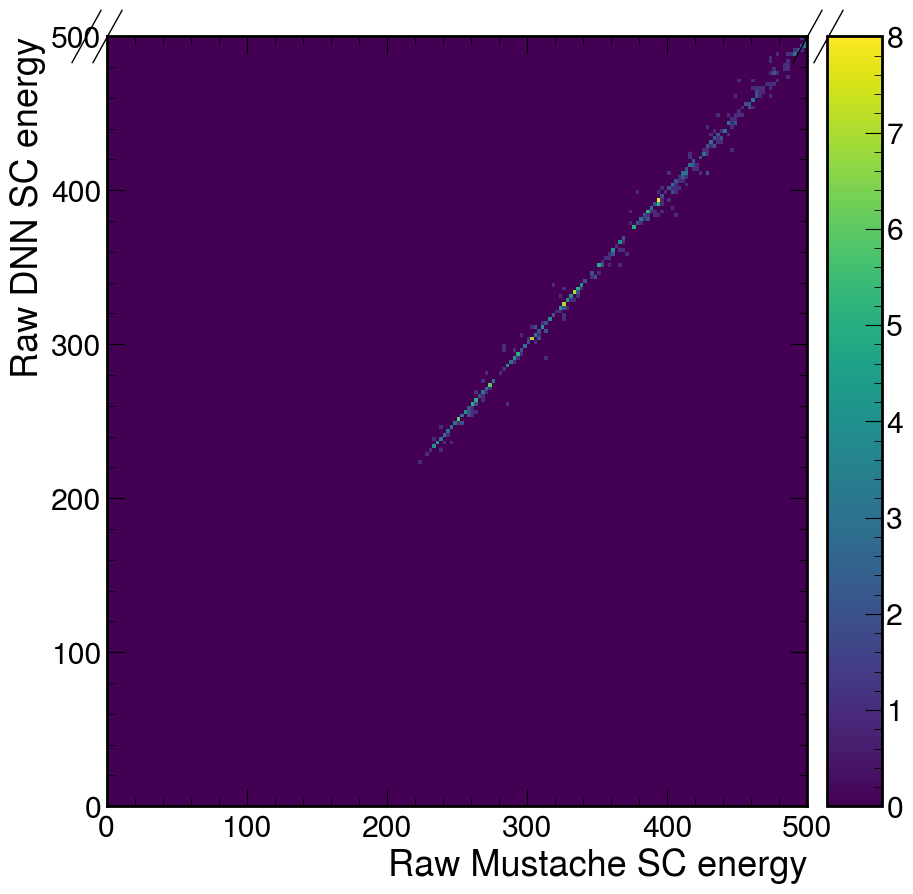

In [24]:
hep.hist2dplot(h_mustache_dnn_comp[{"seedPt":7}])

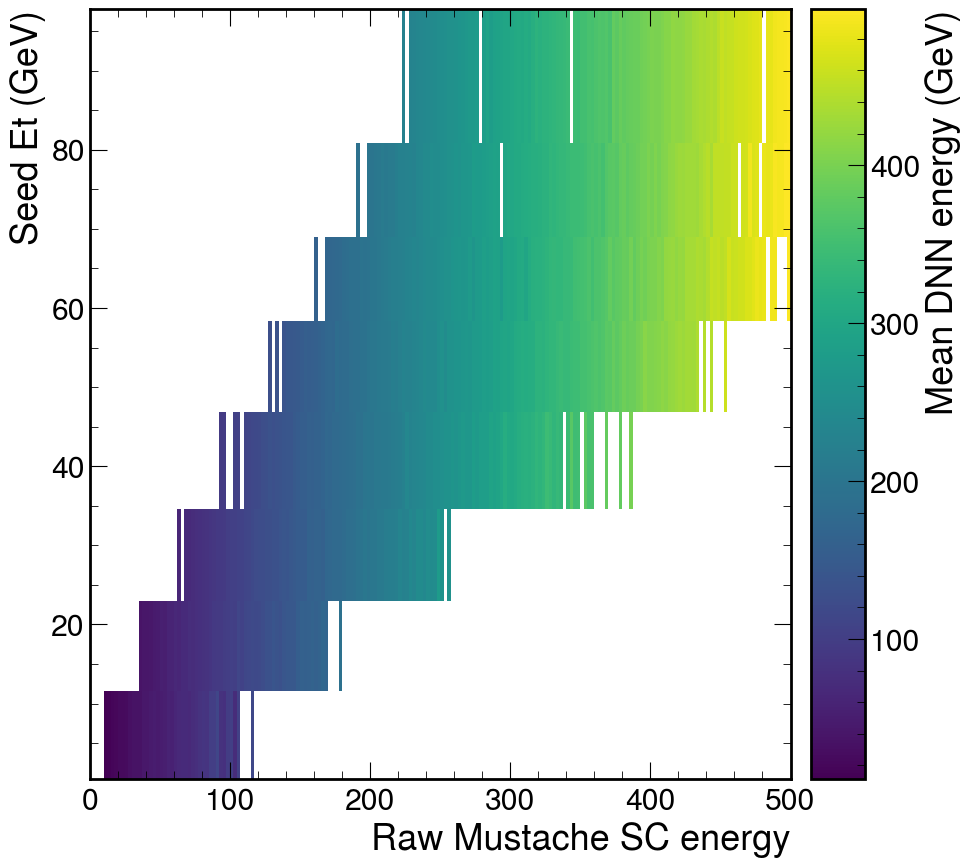

In [25]:
hep.hist2dplot(h_mustache_dnn_comp.profile("dnnEnergy")).cbar.set_label("Mean DNN energy (GeV)")

Text(0, 1, 'Average DNN supercluster energy (GeV)')

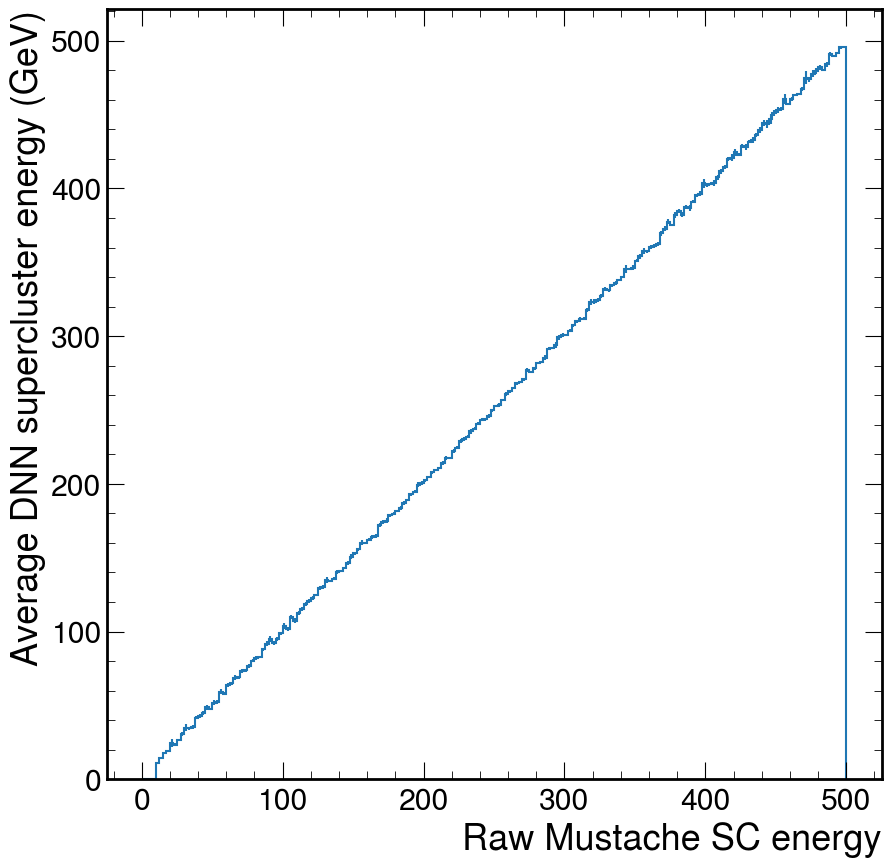

In [28]:
hep.histplot(h_mustache_dnn_comp.profile("dnnEnergy")[{"seedPt":hist.sum}], yerr=None)
plt.ylabel("Average DNN supercluster energy (GeV)")

In [33]:
h_mustache_dnn_sc_sub  = hist.Hist(
                        hist.axis.Regular(100, -30, 30., name="mustacheMinusDNN", label="Mustache - DNN energy"),
                        hist.axis.Regular(100, 0., 600., name="CP_energy", label="CaloParticle energy (GeV)")
                          ).fill(mustacheMinusDNN=DNN_mustache_comp_df.raw_energy_supercls_sum_mustache-DNN_mustache_comp_df.raw_energy_supercls_sum_DNN, CP_energy=DNN_mustache_comp_df.regressed_energy_CP)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fc494306890>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fc4945b9bd0>, text=[])

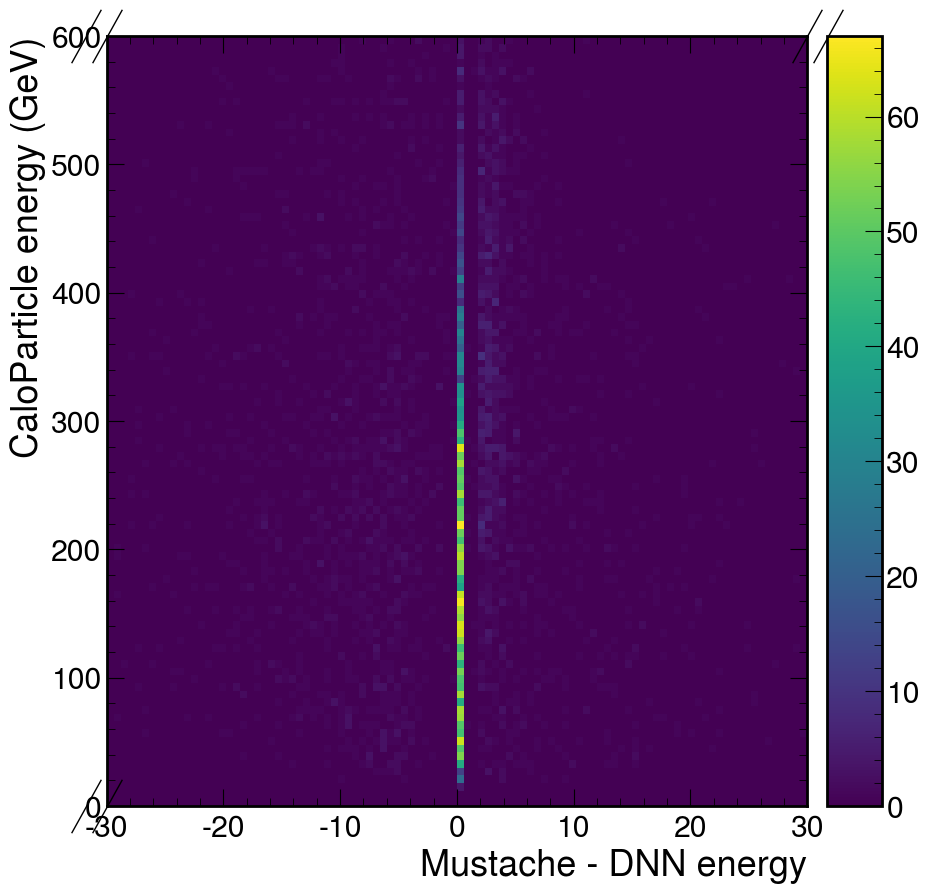

In [34]:
cmap = hep.hist2dplot(h_mustache_dnn_sc_sub).cmap